In [1]:
import datetime, calendar, glob, os

import pickle as pkl

import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import properscoring as ps
import scipy.stats as stats
import seaborn as sns

from ipywidgets import *
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.integrate import quad
from scipy.stats import multivariate_normal, norm
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.transforms import ScaledTranslation
from scipy.signal import correlate

from functional_utils import _fDepth, _fQuantile

from loading_utils import (_process_wind_metadata,
                           _process_solar_metadata)

from scores_utils import *

plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handleheight"] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_fDepth = "/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth"
path_to_data   = "/Users/Guille/Desktop/dynamic_update/data"
path_to_images = "/Users/Guille/Desktop/dynamic_update/images"

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

# Timestamps in interval
T = 288

In [2]:
def _find_common_elements(a, b):

    # Get common values
    common = np.intersect1d(a, b)
    
    # Get indices in a
    idx_a = np.nonzero(np.isin(a, common))[0]
    
    # Get indices in b
    idx_b = np.nonzero(np.isin(b, common))[0]

    return idx_a, idx_b
    
def _find_lag(F_tr_, E_tr_):
    
    tA = np.linspace(0, F_tr_.shape[0] - 1, F_tr_.shape[0])
    tA = tA - tA.mean()
    
    tB = np.linspace(0, E_tr_.shape[0] - 1, E_tr_.shape[0])
    tB = tB - tB.mean()
    
    lags_ = []
    for k in range(F_tr_.shape[-1]):
    
        A = F_tr_[:, k]
        B = E_tr_[:, k]
        tB_aligned = tB

        # Compute cross-correlation
        corr = correlate(B, A, mode='full')
        lags = np.arange(-len(A) + 1, len(B))
        
        # Find the lag with max correlation
        lag = lags[np.argmax(corr)]
        #print(f"Estimated lag: {lag} samples")
            
        lags_.append(lag)

    return np.mean(lags_), np.median(lags_), stats.mode(lags_, keepdims=True)[0][0]

(187,) (187, 2)
(104544, 187)
-371.7379679144385 -371.0 -369
(105120,) (104544,)
(105120, 187) (104544, 187) (105120, 1)
(104544, 187) (104544, 187) (104544, 1)


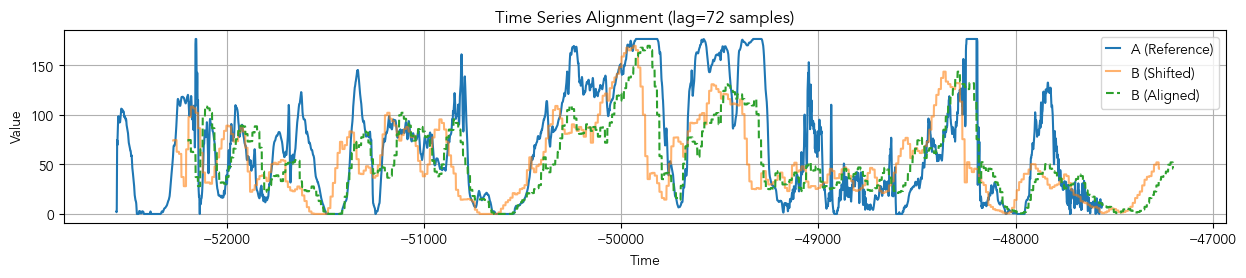

[['2017-01-02 06:00:00']
 ['2017-01-02 06:05:00']
 ['2017-01-02 06:10:00']
 ...
 ['2017-12-31 05:45:00']
 ['2017-12-31 05:50:00']
 ['2017-12-31 05:55:00']]
['2017-01-02 00:00:00' '2017-01-02 00:05:00' '2017-01-02 00:10:00' ...
 '2017-12-30 23:45:00' '2017-12-30 23:50:00' '2017-12-30 23:55:00']
(363, 288, 187) (363, 288, 187)


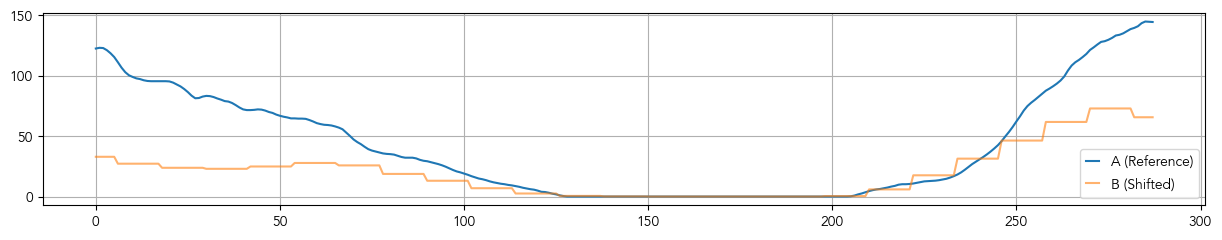

In [21]:
# Loading and processing of sites metadata
meta_ = _process_wind_metadata(path_to_data, "/wind_meta.xlsx")

assets_ = meta_.index
meta_   = meta_.reset_index(drop=False)
X_tr_   = meta_[["lon", "lat"]].to_numpy()
idx_    = np.unique(X_tr_, return_index=True, axis=0)[1]
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
idx_    = np.argsort(assets_)
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
print(assets_.shape, X_tr_.shape)

ac_tr_ = pd.read_csv(path_to_data + "/actuals/wind_actual_5min_site_2017.csv")
dates_ = ac_tr_[['Time']].to_numpy()
# Consitent asset ordering
F_tr_  = ac_tr_[assets_].to_numpy()

# Consitent asset ordering
fc_ = pd.read_csv(path_to_data + "/actuals/wind_day_ahead_forecast_2017.csv")
fc_ = fc_[assets_].to_numpy()

# Interpolate 24h day-ahead forecast to 5min intervals
E_tr_ = []
x_fc_ = np.linspace(0, fc_.shape[0] - 1, fc_.shape[0])*12
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)
for k in range(assets_.shape[0]):
    fc_tr_ = interpolate.interp1d(x_fc_, fc_[:, k], kind       = 'nearest-up', 
                                                    #kind       = 'quadratic', 
                                                    fill_value = "extrapolate")(x_ac_)
    E_tr_.append(fc_tr_[:, np.newaxis])
E_tr_ = np.concatenate(E_tr_, axis = 1)
print(E_tr_.shape)

mean_lag, med_lag, mod_lag = _find_lag(F_tr_, E_tr_)
print(mean_lag, med_lag, mod_lag)

lag = 6*12
    
tA = np.linspace(0, F_tr_.shape[0] - 1, F_tr_.shape[0])
tA = tA - tA.mean()
tB = np.linspace(0, E_tr_.shape[0] - 1, E_tr_.shape[0])
tB = tB - tB.mean()
tB_aligned = tB + lag
print(tA.shape, tB_aligned.shape)

idx_A_, idx_B_ = _find_common_elements(tA, tB_aligned)
print(F_tr_.shape, E_tr_.shape, dates_.shape)

F_tr_p_  = F_tr_[idx_A_, :]
E_tr_p_  = E_tr_[idx_B_, :]
dates_p_ = dates_[idx_A_]
print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

k = 0
N = 5000

plt.figure(figsize=(15, 2.5))
plt.plot(tA[:N], F_tr_[:N, k], label='A (Reference)')
plt.plot(tB[:N], E_tr_[:N, k], label='B (Shifted)', alpha=0.6)
plt.plot(tB_aligned[:N], E_tr_[:N, k], label='B (Aligned)', linestyle='--')
plt.legend()
plt.title(f"Time Series Alignment (lag={lag} samples)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

print(dates_p_)

# shift    =  6*12
# F_tr_p_  = F_tr_p_[shift:(shift - 288)]
# E_tr_p_  = E_tr_p_[shift:(shift - 288)]
# dates_p_ = dates_p_[shift:(shift - 288)]
# print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

dates_p_ = np.array([(datetime.datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S')
                      - datetime.timedelta(hours = 6)).strftime('%Y-%m-%d %H:%M:%S') 
                     for x in dates_p_])
print(dates_p_)

F_tr_pp_ = F_tr_p_.reshape(-1, 288, assets_.shape[0])
E_tr_pp_ = E_tr_p_.reshape(-1, 288, assets_.shape[0])
print(F_tr_pp_.shape, E_tr_pp_.shape)

plt.figure(figsize=(15, 2.5))
plt.plot(F_tr_pp_[2, :, 0], label='A (Reference)')
plt.plot(E_tr_pp_[2, :, 0], label='B (Shifted)', alpha=0.6)
plt.legend()
plt.grid(True)
plt.show()

# Your data (can be a dict, list, NumPy array, model, etc.)
_data = {"assets": assets_, 
         "locations": X_tr_, 
         "dates": dates_p_, 
         "observations": F_tr_p_, 
         "forecasts": E_tr_p_}

# Save to pickle file
with open(path_to_data + "/preprocessed_wind_2017.pkl", "wb") as f:
    pkl.dump(_data, f)

(187,) (187, 2)
(105120, 187)
57.9144385026738 59.0 59
(105120,) (105120,)
(105120, 187) (105120, 187) (105120, 1)
(105048, 187) (105048, 187) (105048, 1)


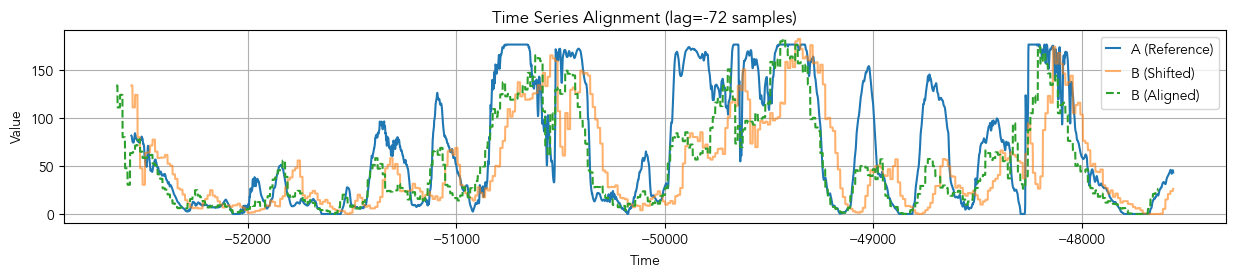

[['2018-01-01 00:00:00']
 ['2018-01-01 00:05:00']
 ['2018-01-01 00:10:00']
 ...
 ['2018-12-31 17:45:00']
 ['2018-12-31 17:50:00']
 ['2018-12-31 17:55:00']]
(104832, 187) (104832, 187) (104832, 1)
['2018-01-01 00:00:00' '2018-01-01 00:05:00' '2018-01-01 00:10:00' ...
 '2018-12-30 23:45:00' '2018-12-30 23:50:00' '2018-12-30 23:55:00']
(364, 288, 187) (364, 288, 187)


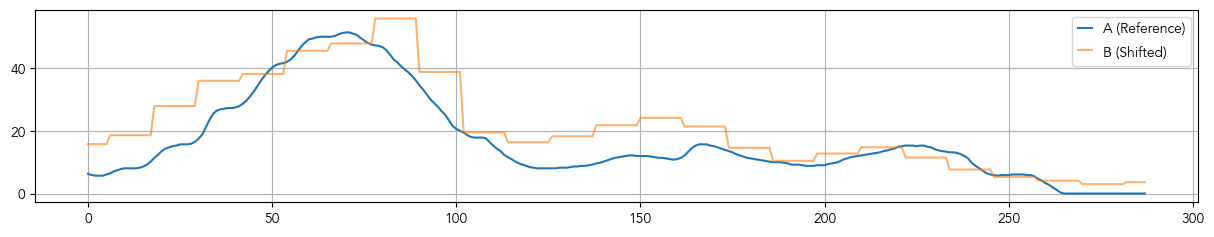

In [20]:
# Loading and processing of sites metadata
meta_ = _process_wind_metadata(path_to_data, "/wind_meta.xlsx")

assets_ = meta_.index
meta_   = meta_.reset_index(drop=False)
X_tr_   = meta_[["lon", "lat"]].to_numpy()
idx_    = np.unique(X_tr_, return_index=True, axis=0)[1]
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
idx_    = np.argsort(assets_)
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
print(assets_.shape, X_tr_.shape)

ac_tr_ = pd.read_csv(path_to_data + "/actuals/wind_actual_5min_site_2018.csv")
dates_ = ac_tr_[['Time']].to_numpy()
# Consitent asset ordering
F_tr_  = ac_tr_[assets_].to_numpy()

# Consitent asset ordering
fc_ = pd.read_csv(path_to_data + "/actuals/wind_day_ahead_forecast_2018.csv")
fc_ = fc_[assets_].to_numpy()

# Interpolate 24h day-ahead forecast to 5min intervals
E_tr_ = []
x_fc_ = np.linspace(0, fc_.shape[0] - 1, fc_.shape[0])*12
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)
for k in range(assets_.shape[0]):
    fc_tr_ = interpolate.interp1d(x_fc_, fc_[:, k], kind       = 'nearest-up', 
                                                    #kind       = 'linear', 
                                                    fill_value = "extrapolate")(x_ac_)

    E_tr_.append(fc_tr_[:, np.newaxis])
E_tr_ = np.concatenate(E_tr_, axis = 1)
print(E_tr_.shape)

mean_lag, med_lag, mod_lag = _find_lag(F_tr_, E_tr_)
print(mean_lag, med_lag, mod_lag)

lag = -6*12
    
tA = np.linspace(0, F_tr_.shape[0] - 1, F_tr_.shape[0])
tA = tA - tA.mean()
tB = np.linspace(0, E_tr_.shape[0] - 1, E_tr_.shape[0])
tB = tB - tB.mean()

tB_aligned = tB + lag
print(tA.shape, tB_aligned.shape)

idx_A_, idx_B_ = _find_common_elements(tA, tB_aligned)
print(F_tr_.shape, E_tr_.shape, dates_.shape)

F_tr_p_  = F_tr_[idx_A_, :]
E_tr_p_  = E_tr_[idx_B_, :]
dates_p_ = dates_[idx_A_]
print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

k = 0
N = 5000

plt.figure(figsize=(15, 2.5))
plt.plot(tA[:N], F_tr_[:N, k], label='A (Reference)')
plt.plot(tB[:N], E_tr_[:N, k], label='B (Shifted)', alpha=0.6)
plt.plot(tB_aligned[:N], E_tr_[:N, k], label='B (Aligned)', linestyle='--')
plt.legend()
plt.title(f"Time Series Alignment (lag={lag} samples)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

print(dates_p_)

shift    = 6*12
F_tr_p_  = F_tr_p_[shift:-(288 - 2*shift)]
E_tr_p_  = E_tr_p_[shift:-(288 - 2*shift)]
dates_p_ = dates_p_[shift:-(288 - 2*shift)]
print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

dates_p_ = np.array([(datetime.datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S')
                      - datetime.timedelta(hours = 6)).strftime('%Y-%m-%d %H:%M:%S') 
                     for x in dates_p_])
print(dates_p_)

F_tr_pp_ = F_tr_p_.reshape(-1, 288, assets_.shape[0])
E_tr_pp_ = E_tr_p_.reshape(-1, 288, assets_.shape[0])
print(F_tr_pp_.shape, E_tr_pp_.shape)

plt.figure(figsize=(15, 2.5))
plt.plot(F_tr_pp_[2, :, 0], label='A (Reference)')
plt.plot(E_tr_pp_[2, :, 0], label='B (Shifted)', alpha=0.6)
plt.legend()
plt.grid(True)
plt.show()

# Your data (can be a dict, list, NumPy array, model, etc.)
_data = {"assets": assets_, 
         "locations": X_tr_, 
         "dates": dates_p_, 
         "observations": F_tr_p_, 
         "forecasts": E_tr_p_}

# Save to pickle file
with open(path_to_data + "/preprocessed_wind_2018.pkl", "wb") as f:
    pkl.dump(_data, f)

(211,) (211, 2)
(104544, 211)
-360.3601895734597 -360.0 -360
(105120,) (104544,)
(105120, 211) (104544, 211) (105120, 1)
(104544, 211) (104544, 211) (104544, 1)


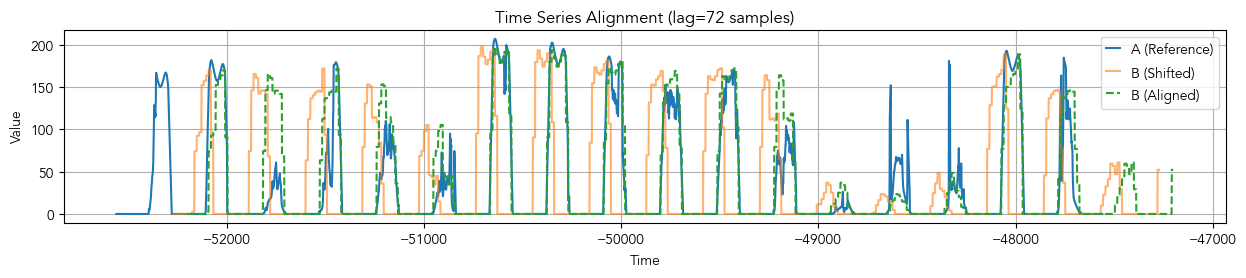

[['2017-01-02 06:00:00']
 ['2017-01-02 06:05:00']
 ['2017-01-02 06:10:00']
 ...
 ['2017-12-31 05:45:00']
 ['2017-12-31 05:50:00']
 ['2017-12-31 05:55:00']]
(104544,)
(363, 288, 211) (363, 288, 211)


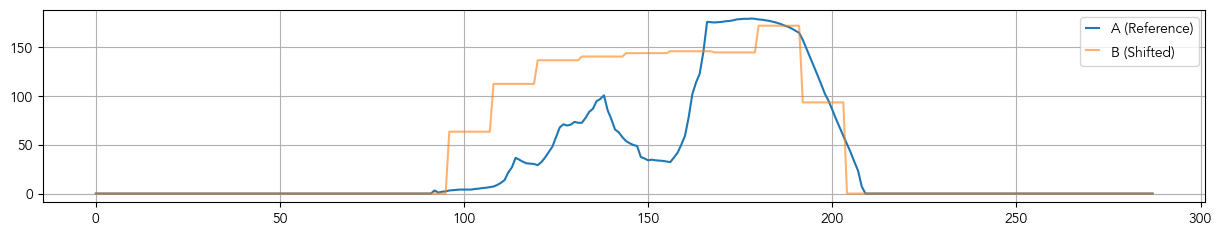

In [28]:
# Loading and processing of sites metadata
meta_ = _process_solar_metadata(path_to_data, '/solar_meta_new.csv')

assets_ = meta_.index
meta_   = meta_.reset_index(drop = False)
X_tr_   = meta_[['lon', 'lat']].to_numpy()
idx_    = np.unique(X_tr_, return_index = True,  axis = 0)[1]
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
idx_    = np.argsort(assets_)
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
print(assets_.shape, X_tr_.shape)

ac_tr_ = pd.read_csv(path_to_data + "/actuals/solar_actual_5min_site_2017.csv")
dates_ = ac_tr_[['Time']].to_numpy()
# Consitent asset ordering
F_tr_  = ac_tr_[assets_].to_numpy()

# Consitent asset ordering
fc_ = pd.read_csv(path_to_data + "/actuals/solar_day_ahead_forecast_2017.csv")
fc_ = fc_[assets_].to_numpy()

# Interpolate 24h day-ahead forecast to 5min intervals
E_tr_ = []
x_fc_ = (np.linspace(0, fc_.shape[0] - 1, fc_.shape[0]) + 0.5)*12
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)
for k in range(assets_.shape[0]):
    fc_tr_ = interpolate.interp1d(x_fc_, fc_[:, k], kind       = 'nearest-up', 
                                                    #kind       = 'linear', 
                                                    fill_value = "extrapolate")(x_ac_)
    E_tr_.append(fc_tr_[:, np.newaxis])
E_tr_ = np.concatenate(E_tr_, axis = 1)
print(E_tr_.shape)

mean_lag, med_lag, mod_lag = _find_lag(F_tr_, E_tr_)
print(mean_lag, med_lag, mod_lag)

lag = 288 + 6*12
lag = 6*12

tA = np.linspace(0, F_tr_.shape[0] - 1, F_tr_.shape[0])
tA = tA - tA.mean()
tB = np.linspace(0, E_tr_.shape[0] - 1, E_tr_.shape[0])
tB = tB - tB.mean()
tB_aligned = tB + lag
print(tA.shape, tB_aligned.shape)

idx_A_, idx_B_ = _find_common_elements(tA, tB_aligned)
print(F_tr_.shape, E_tr_.shape, dates_.shape)

F_tr_p_  = F_tr_[idx_A_, :]
E_tr_p_  = E_tr_[idx_B_, :]
dates_p_ = dates_[idx_A_]
print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

k = 0
N = 5000

plt.figure(figsize=(15, 2.5))
plt.plot(tA[:N], F_tr_[:N, k], label='A (Reference)')
plt.plot(tB[:N], E_tr_[:N, k], label='B (Shifted)', alpha=0.6)
plt.plot(tB_aligned[:N], E_tr_[:N, k], label='B (Aligned)', linestyle='--')
plt.legend()
plt.title(f"Time Series Alignment (lag={lag} samples)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

print(dates_p_)

# F_tr_p_  = F_tr_p_[6*12:(6*12 - 288)]
# E_tr_p_  = E_tr_p_[6*12:(6*12 - 288)]
# dates_p_ = dates_p_[6*12:(6*12 - 288)]
# print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

dates_p_ = np.array([(datetime.datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S')
                      - datetime.timedelta(hours = 6)).strftime('%Y-%m-%d %H:%M:%S') 
                     for x in dates_p_])
print(dates_p_.shape)

F_tr_pp_ = F_tr_p_.reshape(-1, 288, assets_.shape[0])
E_tr_pp_ = E_tr_p_.reshape(-1, 288, assets_.shape[0])
print(F_tr_pp_.shape, E_tr_pp_.shape)

plt.figure(figsize=(15, 2.5))
plt.plot(F_tr_pp_[2, :, 0], label='A (Reference)')
plt.plot(E_tr_pp_[2, :, 0], label='B (Shifted)', alpha=0.6)
plt.legend()
plt.grid(True)
plt.show()

# Your data (can be a dict, list, NumPy array, model, etc.)
_data = {"assets": assets_, 
         "locations": X_tr_, 
         "dates": dates_p_, 
         "observations": F_tr_p_, 
         "forecasts": E_tr_p_}

# Save to pickle file
with open(path_to_data + "/preprocessed_solar_2017.pkl", "wb") as f:
    pkl.dump(_data, f)

(211,) (211, 2)
(105120, 211)
-0.6398104265402843 -1.0 -1
(105120,) (105120,)
(105120, 211) (105120, 211) (105120, 1)
(105120, 211) (105120, 211) (105120, 1)


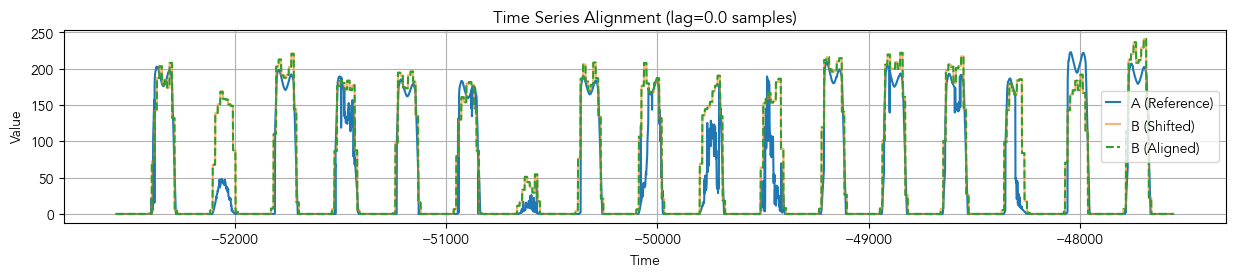

[['2018-01-01 00:00:00']
 ['2018-01-01 00:05:00']
 ['2018-01-01 00:10:00']
 ...
 ['2018-12-31 23:45:00']
 ['2018-12-31 23:50:00']
 ['2018-12-31 23:55:00']]
(104832, 211) (104832, 211) (104832, 1)
['2018-01-01 00:00:00' '2018-01-01 00:05:00' '2018-01-01 00:10:00' ...
 '2018-12-30 23:45:00' '2018-12-30 23:50:00' '2018-12-30 23:55:00']
(364, 288, 211) (364, 288, 211)


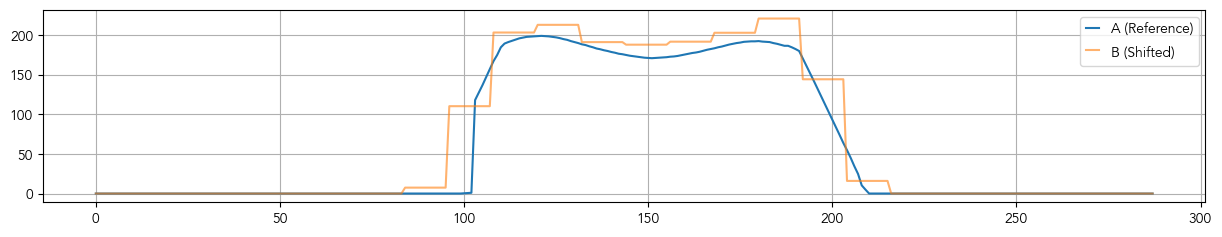

In [29]:
# Loading and processing of sites metadata
meta_ = _process_solar_metadata(path_to_data, '/solar_meta_new.csv')

assets_ = meta_.index
meta_   = meta_.reset_index(drop = False)
X_tr_   = meta_[['lon', 'lat']].to_numpy()
idx_    = np.unique(X_tr_, return_index = True,  axis = 0)[1]
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
idx_    = np.argsort(assets_)
assets_ = assets_[idx_]
X_tr_   = X_tr_[idx_, :]
print(assets_.shape, X_tr_.shape)

ac_tr_ = pd.read_csv(path_to_data + "/actuals/solar_actual_5min_site_2018.csv")
dates_ = ac_tr_[['Time']].to_numpy()
# Consitent asset ordering
F_tr_  = ac_tr_[assets_].to_numpy()

# Consitent asset ordering
fc_ = pd.read_csv(path_to_data + "/actuals/solar_day_ahead_forecast_2018.csv")
fc_ = fc_[assets_].to_numpy()

# Interpolate 24h day-ahead forecast to 5min intervals
E_tr_ = []
x_fc_ = (np.linspace(0, fc_.shape[0] - 1, fc_.shape[0]) +.5)*12 
x_ac_ = np.linspace(0, fc_.shape[0]*12 - 1, fc_.shape[0]*12)
for k in range(assets_.shape[0]):
    fc_tr_ = interpolate.interp1d(x_fc_, fc_[:, k], kind       = 'nearest-up', 
                                                    #kind       = 'linear', 
                                                    fill_value = "extrapolate")(x_ac_)
    E_tr_.append(fc_tr_[:, np.newaxis])
E_tr_ = np.concatenate(E_tr_, axis = 1)
print(E_tr_.shape)

mean_lag, med_lag, mod_lag = _find_lag(F_tr_, E_tr_)
print(mean_lag, med_lag, mod_lag)

lag = 0.
    
tA = np.linspace(0, F_tr_.shape[0] - 1, F_tr_.shape[0])
tA = tA - tA.mean()
tB = np.linspace(0, E_tr_.shape[0] - 1, E_tr_.shape[0])
tB = tB - tB.mean()
tB_aligned = tB + lag
print(tA.shape, tB_aligned.shape)

idx_A_, idx_B_ = _find_common_elements(tA, tB_aligned)
print(F_tr_.shape, E_tr_.shape, dates_.shape)

F_tr_p_  = F_tr_[idx_A_, :]
E_tr_p_  = E_tr_[idx_B_, :]
dates_p_ = dates_[idx_A_]
print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

k = 0
N = 5000

plt.figure(figsize=(15, 2.5))
plt.plot(tA[:N], F_tr_[:N, k], label='A (Reference)')
plt.plot(tB[:N], E_tr_[:N, k], label='B (Shifted)', alpha=0.6)
plt.plot(tB_aligned[:N], E_tr_[:N, k], label='B (Aligned)', linestyle='--')
plt.legend()
plt.title(f"Time Series Alignment (lag={lag} samples)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

print(dates_p_)

shift    = 6*12
F_tr_p_  = F_tr_p_[shift:(shift - 288)]
E_tr_p_  = E_tr_p_[shift:(shift - 288)]
dates_p_ = dates_p_[shift:(shift - 288)]
print(F_tr_p_.shape, E_tr_p_.shape, dates_p_.shape)

dates_p_ = np.array([(datetime.datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S')
                      - datetime.timedelta(hours = 6)).strftime('%Y-%m-%d %H:%M:%S') 
                     for x in dates_p_])
print(dates_p_)

F_tr_pp_ = F_tr_p_.reshape(-1, 288, assets_.shape[0])
E_tr_pp_ = E_tr_p_.reshape(-1, 288, assets_.shape[0])
print(F_tr_pp_.shape, E_tr_pp_.shape)

plt.figure(figsize=(15, 2.5))
plt.plot(F_tr_pp_[2, :, 0], label='A (Reference)')
plt.plot(E_tr_pp_[2, :, 0], label='B (Shifted)', alpha=0.6)
plt.legend()
plt.grid(True)
plt.show()

# Your data (can be a dict, list, NumPy array, model, etc.)
_data = {"assets": assets_, 
         "locations": X_tr_, 
         "dates": dates_p_, 
         "observations": F_tr_p_, 
         "forecasts": E_tr_p_}

# Save to pickle file
with open(path_to_data + "/preprocessed_solar_2018.pkl", "wb") as f:
    pkl.dump(_data, f)